### Autologger

Requires:
* RuneLite

Limitations:
* Maple

Setup:
* Open Bag
* Drop Chat Window
* Zoom to 50% of max
* Point Camera North
* Set items you dont want to drop

In [1]:
#User Settings
#Type in the game window name
window_name = "RuneLite - Jal Z0r"
#Items to drop as a python list i.e. [1, 2, 3, 15]
drop = list(range(1, 29)[:])

### Initialization
* Import/Install Dependencies
* Set Game Window Size
* Move Game Window to Specific Location

In [2]:
import pyautogui as ag
import cv2 as cv
import numpy as np
import pygetwindow as pgw
from matplotlib import pyplot as plt
from pynput.mouse import Button, Controller as MouseController
from pynput.keyboard import Key, Controller as KeyboardController
import time
import pytesseract
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

#set up game screen
game_window = pgw.getWindowsWithTitle(window_name)[0]
game_window.moveTo(0,0)
game_window.resizeTo(1000,800)

#load images
images = {"logging" : None, "not_logging" : None,
          "maple_tree" : None, "log_pile" : None}

for i, v in enumerate(images):
    image = cv.imread(v + ".jpg")
    image = cv.cvtColor(np.array(image), cv.COLOR_BGR2GRAY)
    images[v] = image

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5, forward=True)
name = "test.jpg"
def test_grab():
    image = ag.screenshot()
    image = cv.cvtColor(np.array(image), cv.COLOR_BGR2GRAY)
    x, y, h, w = 0, 0, 800, 1000
    image = image[y:y+h, x:x+w]
    cv.imwrite(name, image)
test_grab()
image = cv.imread(name)
plt.imshow(image)

# bag locs x, y, h, w = 750, 700, 250, 200
# fish locs x, y, h, w = 10, 50, 35, 90
#inventory locs x, y, h, w = 800, 500, 250, 180
# interact text x, y, h, w = 5, 27, 20, 70
x, y, h, w = 5, 27, 20, 70
test = image[y:y+h, x:x+w]

plt.title(name)
plt.imshow(test)
#cv.imwrite(name, test)

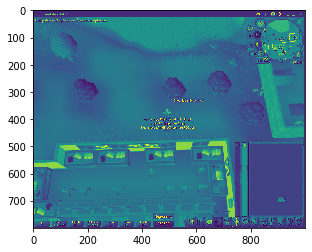

In [3]:
#screengrab
def screen_grab():
    image = ag.screenshot()
    image = cv.cvtColor(np.array(image), cv.COLOR_BGR2GRAY)
    x, y, h, w = 0, 0, 800, 1000
    image = image[y:y+h, x:x+w]
    return image

plt.imshow(screen_grab())

In [4]:
def interact_text_read(image):
    image = image
    x, y, h, w = 5, 27, 20, 70
    crop = image[y:y+h, x:x+w]
    text = pytesseract.image_to_string(crop)
    if text[0:4] == "Chop":
        found = True
    else:
        found = False
    return found

In [5]:
def drop_items(locs):     
    MouseController().position = [400, 10]
    time.sleep(0.5)
    MouseController().click(Button.left, 1)
    time.sleep(0.5)
    for loc in locs:
        x = loc[0]
        y = loc[1]
        with KeyboardController().pressed(Key.shift):
            time.sleep(1)
            MouseController().position = x, y
            time.sleep(0.2)
            MouseController().click(Button.left, 1)
            time.sleep(0.5)

In [6]:
def mse(imageA, imageB):
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1])
    return err

In [7]:
logging = False

def logging_status():
    x, y, h, w = 10, 50, 20, 90
    image = screen_grab()
    image = image[y:y+h, x:x+w]
    if mse(image, images["logging"]) > mse(image, images["not_logging"]):
        logging = False
    else:
        logging = True
    return logging

In [8]:
full = False

def bag_full(inventory_size):
    img_gray = screen_grab()
    x, y, h, w = 800, 500, 250, 180
    img_gray = img_gray[y:y+h, x:x+w]
    template = images['log_pile']
    tw, th = template.shape[::-1]
    res = cv.matchTemplate(img_gray,template,cv.TM_CCOEFF_NORMED)
    threshold = 0.8
    loc = np.where( res >= threshold)
    locs = []
    for lo in zip(*loc[::-1]):
        locs.append([lo[0] + (tw*0.5) + x, lo[1] + th*(0.5) + y])
    if len(loc[0]) < inventory_size:
        full = False
    else:
        full = True
    return full, locs

In [9]:
maple = images['maple_tree']

def log():
    while interact_text_read(screen_grab()) == False:
        time.sleep(0.5)
        x, y = img_find()
        MouseController().position = [x, y]
        time.sleep(0.5)
    MouseController().click(Button.left, 1)
    time.sleep(10)
    return None

In [10]:
import imutils

def img_find():
    # load the image image, convert it to grayscale, and detect edges
    template = cv.Canny(maple, 50, 200)
    (tH, tW) = template.shape[:2]
    #cv.imshow("Template", template)

    image = screen_grab()
    found = None
    for scale in np.linspace(0.2, 1.0, 20)[::-1]:
        resized = imutils.resize(image, width = int(image.shape[1] * scale))
        r = image.shape[1] / float(resized.shape[1])
        # if the resized image is smaller than the template, then break
        # from the loop
        if resized.shape[0] < tH or resized.shape[1] < tW:
            break
        # detect edges in the resized, grayscale image and apply template
        # matching to find the template in the image
        edged = cv.Canny(resized, 50, 200)
        result = cv.matchTemplate(edged, template, cv.TM_CCOEFF)
        (_, maxVal, _, maxLoc) = cv.minMaxLoc(result)
        # draw a bounding box around the detected region
        clone = np.dstack([edged, edged, edged])
        cv.rectangle(clone, (maxLoc[0], maxLoc[1]),
            (maxLoc[0] + tW, maxLoc[1] + tH), (0, 0, 255), 2)
        # if we have found a new maximum correlation value, then update
        # the bookkeeping variable
        if found is None or maxVal > found[0]:
            found = (maxVal, maxLoc, r)
    # unpack the bookkeeping variable and compute the (x, y) coordinates
    # of the bounding box based on the resized ratio
    (_, maxLoc, r) = found
    (startX, startY) = (int(maxLoc[0] * r), int(maxLoc[1] * r))
    (endX, endY) = (int((maxLoc[0] + tW) * r), int((maxLoc[1] + tH) * r))
    # draw a bounding box around the detected result and display the image
    cv.rectangle(image, (startX, startY), (endX, endY), (0, 0, 255), 2)
    x = startX + ((endX - startX)/2)
    y = startY + ((endY - startY)/2)
    return x, y

x, y = img_find()
print(x, y)

692.0 290.0


In [ ]:
while True == True:
    time.sleep(1)
    print("logging status:", logging_status())
    if logging_status() == False:
        bag_status, locs = bag_full(len(drop))
        print("bag_status:", bag_status)
        if bag_status == True:
            print("dropping")
            drop_items(locs)
        else:
            print("logging")
            log()

logging status: True
logging status: True
logging status: False
bag_status: False
logging
logging status: True
logging status: True
logging status: True
logging status: True
logging status: True
logging status: True
logging status: True
logging status: True
logging status: True
logging status: True
logging status: True
logging status: True
logging status: True
logging status: True
logging status: True
logging status: True
logging status: True
logging status: True
logging status: True
logging status: True
logging status: True
logging status: True
logging status: True
logging status: True
logging status: True
logging status: True
logging status: True
logging status: True
logging status: True
logging status: True
logging status: True
logging status: False
bag_status: False
logging
logging status: True
logging status: True
logging status: True
logging status: True
logging status: True
logging status: True
logging status: True
logging status: True
logging status: True
logging status: True
l